In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import shutil

In [25]:
# --- 1. Configuration and Setup ---
# Define paths and parameters
DATASET_PATH = 'Dataset_BUSI_with_GT' # IMPORTANT: Change this to your dataset path
IMAGE_SIZE = (224, 224) # resnet expects 224x224 input
BATCH_SIZE = 32
NUM_CLASSES = 3 # Normal, Benign, Malignant
EPOCHS = 50 # You might need more or less depending on convergence
LEARNING_RATE = 1e-4 # Fine-tuning usually uses a lower learning rate ,-->0.0001
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2 # From the training set
RANDOM_SEED = 42

In [13]:
# Ensure reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [14]:
# --- 2. Data Preparation ---

# Create temporary directories for train, validation, and test splits
base_dir = 'busi_data_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Clean up previous runs if necessary
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [15]:
# Get class names and create subdirectories within train/val/test
class_names = sorted(os.listdir(DATASET_PATH))
if '.DS_Store' in class_names: # Handle potential macOS hidden files
    class_names.remove('.DS_Store')

for cls_name in class_names:
    os.makedirs(os.path.join(train_dir, cls_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls_name), exist_ok=True)

    # Split data
    source_path = os.path.join(DATASET_PATH, cls_name)
    images = os.listdir(source_path)
    if '.DS_Store' in images:
        images.remove('.DS_Store')
    np.random.shuffle(images)

    num_images = len(images)
    num_test = int(num_images * TEST_SPLIT)
    num_val = int((num_images - num_test) * VALIDATION_SPLIT)
    num_train = num_images - num_test - num_val

    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy files to respective directories
    print(f"Splitting class: {cls_name}")
    for img in train_images:
        shutil.copy(os.path.join(source_path, img), os.path.join(train_dir, cls_name, img))
    for img in val_images:
        shutil.copy(os.path.join(source_path, img), os.path.join(val_dir, cls_name, img))
    for img in test_images:
        shutil.copy(os.path.join(source_path, img), os.path.join(test_dir, cls_name, img))

print("\nDataset split complete. Data generators will now be created.")

Splitting class: benign
Splitting class: malignant
Splitting class: normal

Dataset split complete. Data generators will now be created.


In [16]:
# --- 3. Data Augmentation and Generators ---
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [38]:
# Only rescale for validation and test images (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Training")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    seed=RANDOM_SEED
)
print("Validation")
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED
)
print("Testing")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Important for correct evaluation order
    seed=RANDOM_SEED
)

print(f"Class labels: {train_generator.class_indices}")

Training
Found 1012 images belonging to 3 classes.
Validation
Found 251 images belonging to 3 classes.
Testing
Found 315 images belonging to 3 classes.
Class labels: {'benign': 0, 'malignant': 1, 'normal': 2}


In [22]:
# --- 4. Modeling (Transfer Learning with resnet50) ---

# Load pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = Flatten()(x) # Flatten the output from the convolutional base
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout for regularization, as suggested in the paper (implicitly)
output = Dense(NUM_CLASSES, activation='softmax')(x) # Output layer for 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.summary()

94765736/94765736 [==============================] - 54s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                            

In [ ]:
# --- 5. Model Fine-Tuning and Training ---

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for better training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_busi_model_resnet50.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
print("\nStarting initial training of the top layers...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)


Starting initial training of the top layers...
Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5255
Epoch 1: val_loss improved from inf to 0.81555, saving model to best_busi_model_vgg16.h5
31/31 [==============================] - 77s 2s/step - loss: 1.2432 - accuracy: 0.5255 - val_loss: 0.8156 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6010
Epoch 2: val_loss improved from 0.81555 to 0.78207, saving model to best_busi_model_vgg16.h5
31/31 [==============================] - 54s 2s/step - loss: 0.8523 - accuracy: 0.6010 - val_loss: 0.7821 - val_accuracy: 0.6161 - lr: 1.0000e-04
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.6265
Epoch 3: val_loss did not improve from 0.78207
31/31 [==============================] - 54s 2s/step - loss: 0.8521 - accuracy: 0.6265 - val_loss: 0.7894 - val_accuracy: 0.6205 - lr: 1.0000e-04
Epo

In [27]:
# --- Optional: Fine-tuning the entire model (unfreeze some layers) ---
# Unfreeze a few layers from the base model for fine-tuning
# You can experiment with how many layers to unfreeze.
# resnet50 has 50 layers in total. Unfreezing from block5_conv1 onwards is a common strategy.
# The paper suggests fine-tuning the entire network after the initial training of the top layers.
print("\nStarting fine-tuning of the entire model (or last few layers)...")
for layer in base_model.layers:
    layer.trainable = True # Unfreeze all layers of the base model

# Recompile the model with a very low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate= 1e-4 * 0.1), # Even lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for more epochs (e.g., 20-50 more)
# It's good practice to start a new EarlyStopping/ReduceLROnPlateau for fine-tuning phase
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint('final_fine_tuned_busi_model_resnet50.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS + 20, # Train for more epochs
    initial_epoch=history.epoch[-1] + 1, # Start from where previous training left off
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=fine_tune_callbacks
)


# Load the best model saved during fine-tuning for final evaluation
try:
    model = tf.keras.models.load_model('final_fine_tuned_busi_model_resnet50.h5')
    print("Loaded best fine-tuned model for evaluation.")
except:
    print("Could not load 'final_fine_tuned_busi_model_resnet50.h5'. Using the last trained model.")




Starting fine-tuning of the entire model (or last few layers)...
Epoch 51/70
31/31 [==============================] - ETA: 0s - loss: 4.0883 - accuracy: 0.6153
Epoch 51: val_loss improved from inf to 1.58478, saving model to final_fine_tuned_busi_model_resnet50.h5
31/31 [==============================] - 172s 5s/step - loss: 4.0883 - accuracy: 0.6153 - val_loss: 1.5848 - val_accuracy: 0.5759 - lr: 1.0000e-05
Epoch 52/70
31/31 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.7520
Epoch 52: val_loss did not improve from 1.58478
31/31 [==============================] - 157s 5s/step - loss: 1.1997 - accuracy: 0.7520 - val_loss: 1.9837 - val_accuracy: 0.5804 - lr: 1.0000e-05
Epoch 53/70
31/31 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.7929
Epoch 53: val_loss did not improve from 1.58478
31/31 [==============================] - 160s 5s/step - loss: 0.7768 - accuracy: 0.7929 - val_loss: 2.1544 - val_accuracy: 0.5848 - lr: 1.0000e-05
Epoch 5

In [33]:
# --- 6. Evaluation ---

print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for classification report and confusion matrix
test_generator.reset() # Reset generator to ensure predictions are in correct order
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Ensure the lengths match for reporting
# Some images might be left out if the last batch is incomplete in test_generator.
# Adjusting true_classes to match the length of predictions
true_classes_matched = true_classes[:len(predicted_classes)]


print("\nClassification Report:")
print(classification_report(true_classes_matched, predicted_classes, target_names=class_labels))


Evaluating model on the test set...
9/9 [==============================] - 17s 2s/step - loss: 1.4203 - accuracy: 0.6493
Test Loss: 1.4203
Test Accuracy: 0.6493
10/10 [==============================] - 16s 1s/step

Classification Report:
              precision    recall  f1-score   support

      benign       0.58      1.00      0.74       178
   malignant       1.00      0.11      0.19        84
      normal       0.00      0.00      0.00        53

    accuracy                           0.59       315
   macro avg       0.53      0.37      0.31       315
weighted avg       0.60      0.59      0.47       315



d:\Anaconda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix:


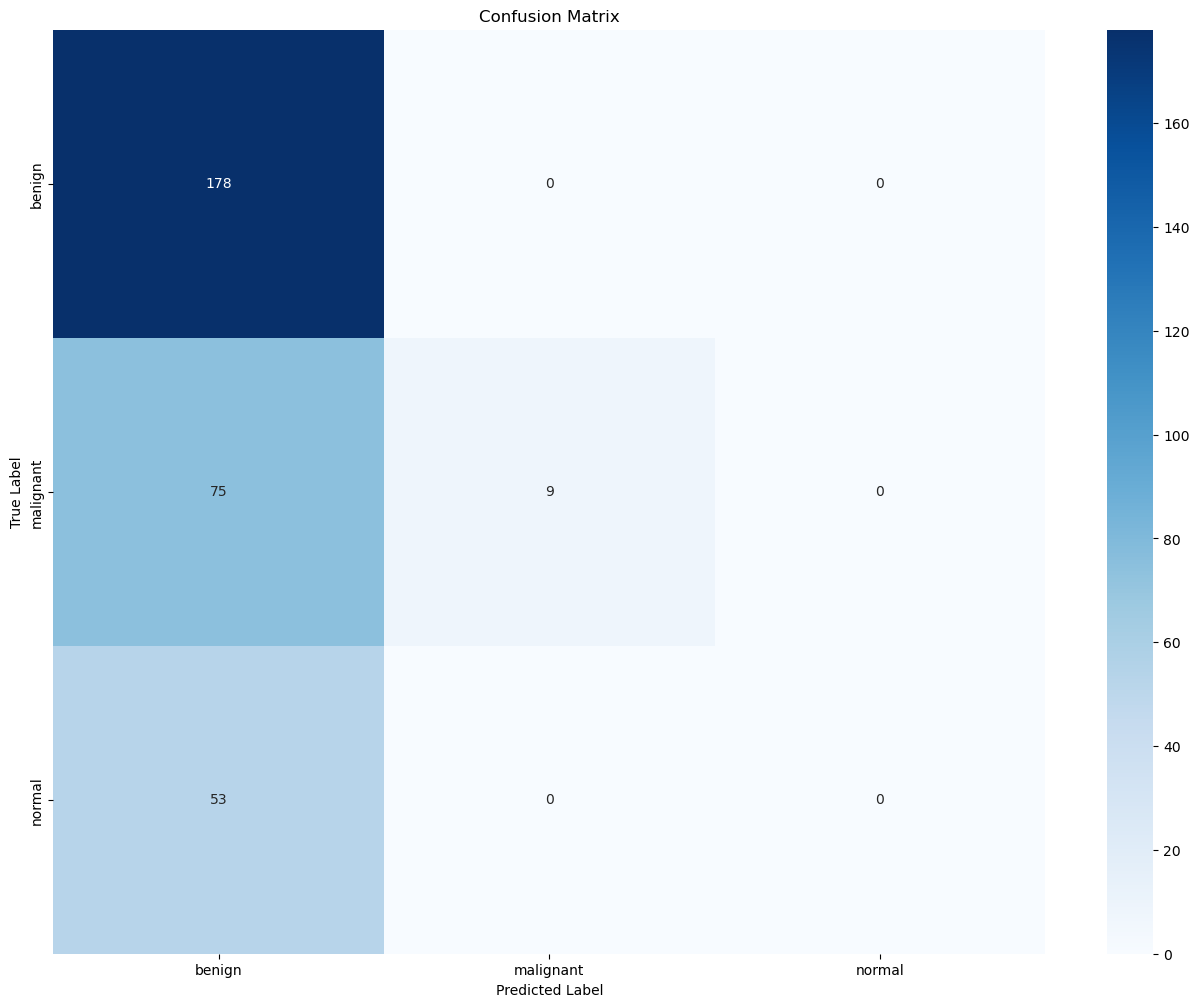

In [34]:
# Plotting the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes_matched, predicted_classes)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

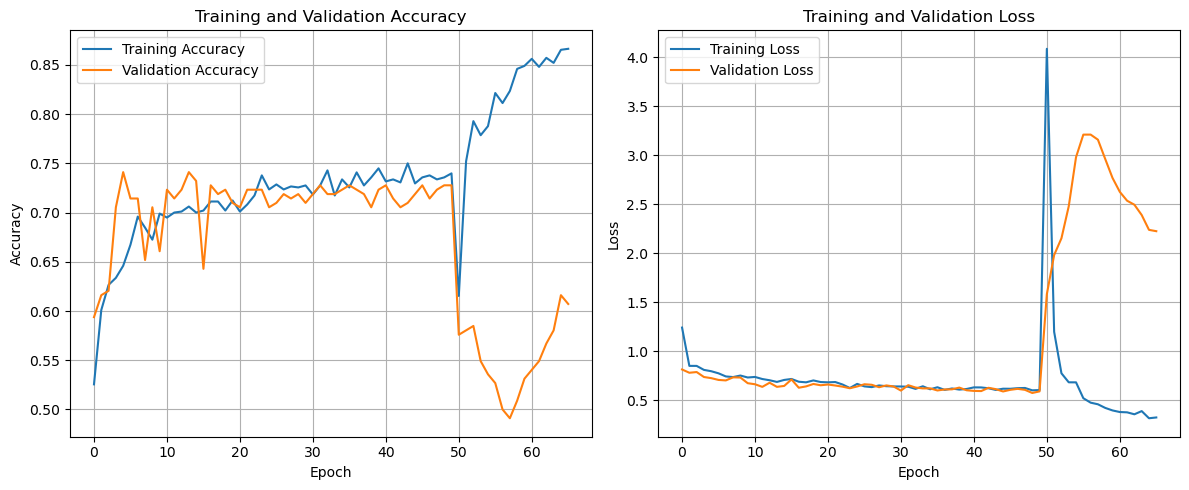


Cleaning up temporary data split directories: busi_data_split


In [35]:
# Plot training history
# Combine histories if fine-tuning was performed
full_history = {}
for key in history.history.keys():
    full_history[key] = history.history[key] + fine_tune_history.history.get(key, [])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Clean up temporary directories ---
print(f"\nCleaning up temporary data split directories: {base_dir}")
# shutil.rmtree(base_dir) # Uncomment this line if you want to remove the split data